In [1]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# Read data
#data = fetch_california_housing()
#X, y = data.data, data.target
df = pd.read_csv('loading_data_max.csv')
df=df.drop_duplicates()

X = df.drop(['filling_space_percent','density_percent'], axis=1)
#X = df['cargo_volume']
y = df['filling_space_percent']/100
y

0      0.817233
1      0.515625
2      0.642438
3      0.672980
4      0.582632
         ...   
620    0.767428
622    0.831830
625    0.000025
626    0.000050
627    0.000248
Name: filling_space_percent, Length: 510, dtype: float64

In [3]:
# train-test split for model evaluation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True,random_state=13)

# Standardizing data
scaler = MinMaxScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
'''X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)'''

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
 


In [4]:
# Define the model
model = nn.Sequential(
    nn.Linear(32, 400),
    nn.ReLU(),
    nn.Linear(400, 400),
    nn.ReLU(),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Linear(100, 1)

)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)
 


In [12]:
n_epochs = 4000   # number of epochs to run
batch_size = 510  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | R^2_NNRegressor: {r2_score(y_test.detach().numpy(), y_pred.detach().numpy()):.4f} MSE:{mse:.4f}')


Epoch: 0 | R^2_NNRegressor: 0.9583 MSE:0.0026
Epoch: 50 | R^2_NNRegressor: 0.9578 MSE:0.0026
Epoch: 100 | R^2_NNRegressor: 0.9577 MSE:0.0026
Epoch: 150 | R^2_NNRegressor: 0.9577 MSE:0.0026
Epoch: 200 | R^2_NNRegressor: 0.9578 MSE:0.0026
Epoch: 250 | R^2_NNRegressor: 0.9578 MSE:0.0026
Epoch: 300 | R^2_NNRegressor: 0.9578 MSE:0.0026
Epoch: 350 | R^2_NNRegressor: 0.9579 MSE:0.0026
Epoch: 400 | R^2_NNRegressor: 0.9579 MSE:0.0026
Epoch: 450 | R^2_NNRegressor: 0.9579 MSE:0.0026
Epoch: 500 | R^2_NNRegressor: 0.9580 MSE:0.0026
Epoch: 550 | R^2_NNRegressor: 0.9580 MSE:0.0026
Epoch: 600 | R^2_NNRegressor: 0.9581 MSE:0.0026
Epoch: 650 | R^2_NNRegressor: 0.9581 MSE:0.0026
Epoch: 700 | R^2_NNRegressor: 0.9581 MSE:0.0026
Epoch: 750 | R^2_NNRegressor: 0.9582 MSE:0.0026
Epoch: 800 | R^2_NNRegressor: 0.9582 MSE:0.0026
Epoch: 850 | R^2_NNRegressor: 0.9583 MSE:0.0026
Epoch: 900 | R^2_NNRegressor: 0.9583 MSE:0.0026
Epoch: 950 | R^2_NNRegressor: 0.9583 MSE:0.0026
Epoch: 1000 | R^2_NNRegressor: 0.9583 MSE:0

MSE: 0.00
RMSE: 0.05


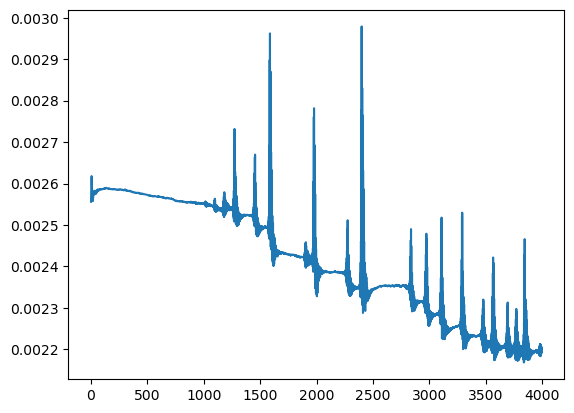

In [13]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [7]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(20):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        #print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
        print(X_sample)
        print(y_pred[0].numpy())
        print(y_test[i].numpy())


tensor([[0.5084, 0.5817, 0.6449, 0.3498, 0.2083, 0.2132, 0.0237, 0.0237, 0.0000,
         0.0014, 0.0135, 0.0135, 0.0000, 0.0000, 0.0000, 0.5436, 1.0000, 0.0362,
         0.5621, 0.0166, 0.0166, 0.0166, 0.0000, 0.0575, 0.4800, 0.4254, 0.4152,
         0.0000, 0.0014, 1.0000, 0.0000, 0.0064]])
[0.56273764]
[0.5350945]
tensor([[5.0838e-01, 5.8167e-01, 6.4494e-01, 3.4978e-01, 2.0826e-01, 2.9438e-01,
         6.9251e-03, 5.2618e-03, 4.1251e-05, 2.9068e-03, 9.0024e-03, 9.0024e-03,
         0.0000e+00, 0.0000e+00, 2.0724e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.9392e-01, 3.3086e-02, 1.8456e-02, 3.0178e-02, 1.9980e-01,
         2.3048e-03, 1.4271e-01, 1.2258e-01, 5.4199e-02, 2.0005e-03, 1.0000e+00,
         1.0000e+00, 3.1638e-02]])
[0.72871065]
[0.738972]
tensor([[6.6480e-01, 5.7617e-01, 7.0637e-01, 4.8741e-01, 2.8736e-01, 9.5840e-02,
         2.3960e-02, 2.3960e-02, 3.4986e-04, 1.4082e-03, 2.4642e-02, 2.4642e-02,
         1.9839e-01, 9.4728e-01, 0.0000e+00, 0.0000e+00